# Fictive Temperature Analysis
## PET aging test performed 29/10/25

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# fix this eventually
import sys
sys.path.insert(0, "../codebase")

from data_parser import parse_mettler_dsc_txt_file, extract_T_and_dsc
from fictive_temp_functions import baseline_correction, fictive_temperature

In [7]:
path = "../Data/tests/PET_aging_test_2.txt"

# parse results from raw file
results = parse_mettler_dsc_txt_file(path)
#results

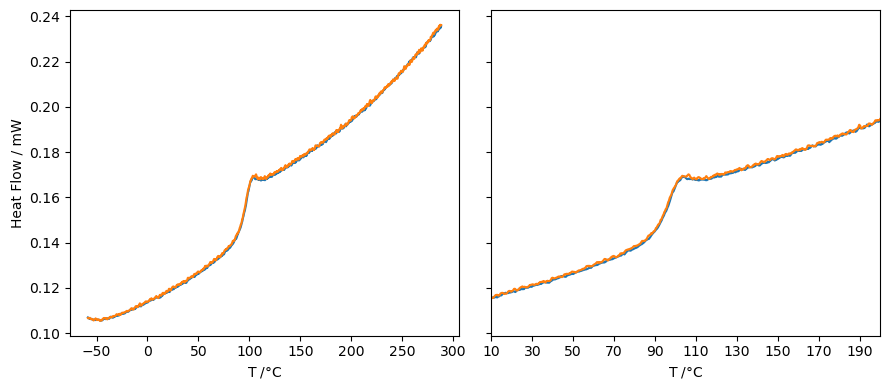

In [15]:
# get only necessary data for analysis
data = extract_T_and_dsc(results)
data_corrected = False

# average reference curves
ref_T = (data[5]["T"] + data[9]["T"]) / 2
ref_dsc = (data[5]["dsc"] + data[9]["dsc"]) / 2

ref = {"T": ref_T, "dsc": ref_dsc}

# remove references from data dict
for i in [5, 9]:
    data.pop(i)

# take last t_a for plotting
sample = data[15]

# plot raw and corrected curves
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
ax1, ax2 = axs
for ax in axs:
    ax.plot(ref["T"], ref["dsc"], label="Reference")
    ax.set_xlabel("T /$\degree$C")

ax1.plot(sample["T"], sample["dsc"], label="Sample")
ax1.set_ylabel("Heat Flow / mW")

ax2.plot(sample["T"], sample["dsc"], label="Sample")
ax2.set_xlim(10, 200)
ax2.set_xticks(range(10, 200, 20))

fig.tight_layout()
plt.show()

In [ ]:
# define temp range for glass and liquid lines, respectively
T1, T2 = (10, 70), (130, 200)

# compute baseline-corrected curve and save
dsc_corrected = baseline_correction(sample, ref, T1, T2)

sample_corrected = sample.copy()
sample_corrected["dsc"] = dsc_corrected

# plot raw and corrected curves
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
ax1, ax2 = axs
for ax in axs:
    ax.plot(ref["T"], ref["dsc"], label="Reference")
    ax.set_xlabel("T /$\degree$C")

ax1.plot(sample["T"], sample["dsc"], label="Sample")
ax1.set_title("Sample and Reference Raw")
ax1.set_ylabel("Heat Flow / mW")

ax2.plot(sample_corrected["T"], sample_corrected["dsc"], label="Corrected Sample")
ax2.set_title("Sample and Reference Corrected")

fig.tight_layout()
for ax in axs:
    ax.legend()
plt.show()

## Apply correction to all curves

Here I am applying a unique correction to each curve, as opposed to computing a global correction. I´m not sure why one should choose one over the other. This seems to make sense to me.

In [ ]:
if data_corrected:
        print("Baseline correction already ran: doing nothing.")
else:
    for curve in data.values():
        curve["dsc"] = baseline_correction(curve, ref, T1, T2)

data_corrected = True

## Compute fictive temperature

In [ ]:
# compute and plot fictive temperature data
Tf_results = fictive_temperature(sample_corrected, T1, T2)

plt.plot(sample_corrected["T"], sample_corrected["dsc"])

T_slice = Tf_results["T_slice"]

plt.plot(T_slice, Tf_results["glass_line"], label="Glass line")
plt.plot(T_slice, Tf_results["liquid_line"], label="Liquid line")
plt.vlines(Tf_results["Tf"], min(sample["dsc"]), max(sample["dsc"]), color="k", linestyles="--", label=f"T$_f$={Tf_results["Tf"]}")
plt.xlabel("T /$\degree$C")
plt.ylabel("Heat Flow / mW")
plt.legend()
plt.show()

In [ ]:
plt.plot(Tf_results["T_slice"], Tf_results["area_liq_minus_glass"], color="red")
plt.plot(Tf_results["T_slice"], Tf_results["area_exp_minus_glass"], color="green")
plt.plot(Tf_results["T_slice"], Tf_results["area_liq_minus_glass"]-Tf_results["area_exp_minus_glass"], color="k")

In [ ]:
print(max(Tf_results["area_exp_minus_glass"]))

Not a great computation. Glass line slope should be greater than liquid line.

## Analyze all curves

In [ ]:
plt.figure()
for curve in data.values():
    plt.plot(curve["T"], curve["dsc"])
plt.xlabel("T /$\degree$C")
plt.ylabel("Heat Flow / mW")
plt.show()

Baseline correction seems to have worked nicely

In [ ]:
# compute aging times (should probably export the times seperately and use the real T_a's)
all_t_a = np.empty_like(list(data.keys()), dtype=float)

i = 0
for e in range(-2, 3):
    for p in [1, 2, 5]:
        all_t_a[i] = p*10**e
        i += 1
        if i == len(all_t_a):
            break

plt.figure()
for i, key in enumerate(sorted(data)):
    Tf_results = fictive_temperature(data[key], T1, T2)
    plt.scatter(all_t_a[i], Tf_results["Tf"])

plt.xscale("log")
plt.xlabel("t$_a$ / s")
plt.ylabel("T$_f$ / $\degree$ C")
plt.show()